# Comparing the accuracy of different models

Here, we compare nonnegative PARAFAC2 (N-PARAFAC2) with MatCoupLy, PARAFAC2 with TensorLy and nonnegative matrix factorization (NMF) with scikit-learn in terms of capturing components with a simulation setup inspired by GCMS data.

N-PARAFAC2 and PARAFAC2 are coupled matrix factorization models, while NMF is a matrix factorization model. For NMF, we therefore decompose the stacked dataset 
$$\mathbf{X} = \begin{bmatrix}
    \mathbf{X}^{(0)} \\
    \mathbf{X}^{(1)} \\
    \vdots \\
    \mathbf{X}^{(I)}
\end{bmatrix}^\mathsf{T},$$
where $\mathbf{X}^{(i)} \in \mathbb{R}^{J \times K}$ is the $i$-th data matrix. This is equivalent to a coupled matrix factorization model with only nonnegativity constraints.

## Imports

In [1]:
import warnings

import matcouply
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorly as tl
import tlviz

from tensorly.decomposition import parafac2
from sklearn.decomposition import NMF
from sklearn.exceptions import ConvergenceWarning
from tlviz.factor_tools import factor_match_score
from scipy import stats

## Utilities for generating simulated datasets

We simulate the data as a collection of shifting Gaussians and one noise component with uniformly distributed component vectors. 

In [2]:
def generate_B_components(I, J, rank, rng):
    """Create components where rank-1 components are shifting Gaussians and the last is uniformly distributed.
    """
    t = np.linspace(-10, 10, J)
    B_is = []
    
    dt = 7/I
    locs = [rng.uniform(-7, 0) for r in range(rank-1)]  # Initial center of the Gaussians
    sigmas = [rng.uniform(0.5, 1) for r in range(rank-1)]  # Width of the Gaussians
    for i in range(I):
        B_i = np.zeros((J, rank))
        
        # Create unimodal component vectors
        for r in range(rank-1):
            loc = locs[r] + i*dt  # Shift the Gaussian i*dt from its initial position
            B_i[:, r] = stats.norm.pdf(t, loc=loc, scale=sigmas[r])
        
        # Create noise component vector
        B_i[:, -1] = rng.uniform(0.5, 1.5, size=J)
        
        # Store factor matrix
        B_is.append(B_i)

    return B_is


def truncated_normal(shape, rng):
    """Draw a truncated normally distributed random variable.
    """
    return np.maximum(0, rng.standard_normal(shape))


def generate_data(shape, rank, noise_level, rng):
    I, J, K = shape
    
    # Create factor-matrices
    A = rng.uniform(0, 1, size=(I, rank))
    B_is = generate_B_components(I, J, rank, rng)
    C = truncated_normal((K, rank), rng)

    # Create the decomposition and construct the dense dataset
    true_cmf = matcouply.coupled_matrices.CoupledMatrixFactorization((None, [A, B_is, C]))
    X_is = true_cmf.to_tensor()
    
    # Add noise with the given noise level
    noise = rng.standard_normal(X_is.shape)
    noise *= noise_level * np.linalg.norm(X_is) / np.linalg.norm(noise)
    noisy_X_is = np.maximum(X_is + noise, 0)
    
    return true_cmf, noisy_X_is

## Visualize an instance of the simulation setup

Here, we plot the simulated components and noisy data for one simulated dataset.

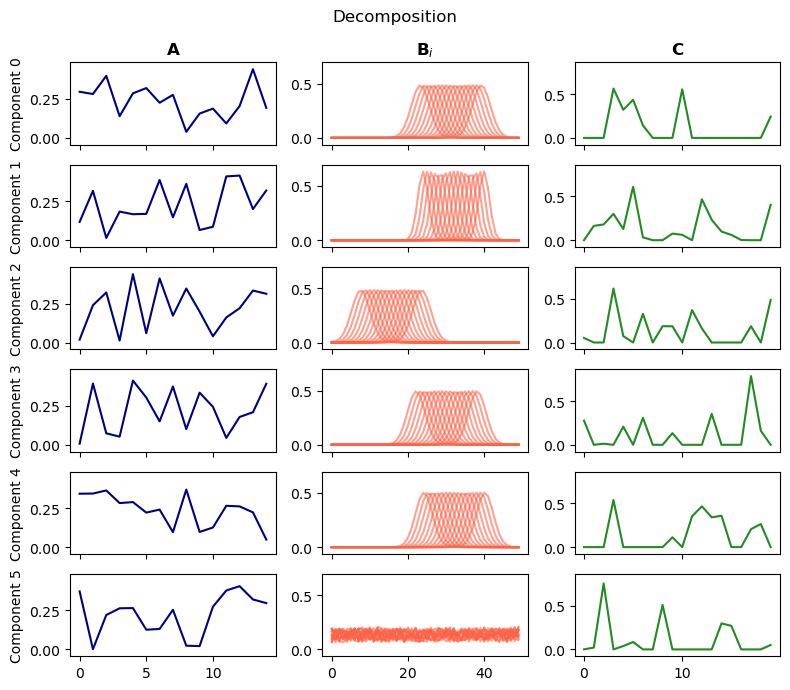

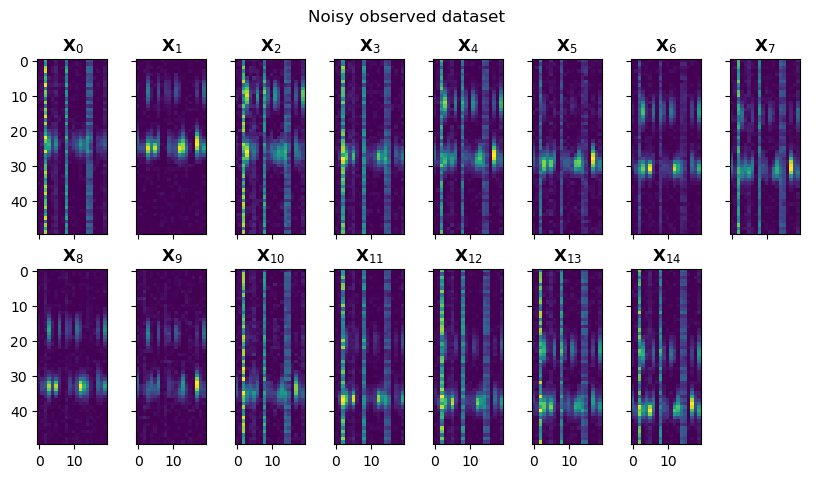

In [3]:
def normalize(x):
    """Normalize x along its first mode (axis).
    """
    return x / np.linalg.norm(x, axis=0, keepdims=True)


example_shape = 15, 50, 20
example_rank = 6
example_noise_level = 0.1
example_rng = np.random.default_rng(0)

example_cmf, example_noisy_X_is = generate_data(example_shape, example_rank, example_noise_level, example_rng)
example_weights, (example_A, example_B_is, example_C) = example_cmf
example_A, example_C = normalize(example_A), normalize(example_C)
example_B_is = np.stack([normalize(B_i) for B_i in example_B_is], axis=0)

fig, axes = plt.subplots(example_cmf.rank, 3, tight_layout=True, figsize=(8, 7))
for r, row in enumerate(axes):
    row[0].set_ylabel(f"Component {r}")
    row[0].plot(example_A[:, r], color="navy")
    row[1].plot(example_B_is[:, :, r].T, color="tomato", alpha=0.6)
    row[2].plot(example_C[:, r], color="forestgreen")

    row[0].set_ylim(-.1*example_A.max(), 1.1*example_A.max())
    row[1].set_ylim(-.1*example_B_is.max(), 1.1*example_B_is.max())
    row[2].set_ylim(-.1*example_C.max(), 1.1*example_C.max())
    if r != example_rank - 1:
        for ax in row:
            xlim = ax.get_xlim()
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels("" for _ in ax.get_xticks())
            ax.set_xlim(xlim)

axes[0, 0].set_title("$\mathbf{A}$")
axes[0, 1].set_title("$\mathbf{B}_{i}$")
axes[0, 2].set_title("$\mathbf{C}$")
fig.suptitle("Decomposition")


fig, axes = plt.subplots(2, round(example_shape[0]/2), sharex=True, sharey=True, figsize=(10, 5))
fig.suptitle("Noisy observed dataset")
for i, (example_noisy_X_i, ax) in enumerate(zip(example_noisy_X_is, axes.ravel())):
    ax.imshow(example_noisy_X_i)
    ax.set_title(f"$\mathbf{{X}}_{{{i}}}$")
axes.ravel()[-1].axis("off")
plt.show()

## Measuring accuracy of decompositions

NMF decomposes the unfolded data matrix, $\mathbf{X}$. To compare the NMF model with the true underlying components, we, therefore, convert the true decomposition into an equivalent matrix factorization model based on the unfolded data matrix. For this, we consider the matrix factorization model $\mathbf{X} \approx \mathbf{C} \tilde{\mathbf{B}}^\mathsf{T}$, where 
$$ \tilde{\mathbf{B}} = \begin{bmatrix}
    \mathbf{B}^{(0)}\mathbf{D}^{(0)} \\
    \mathbf{B}^{(1)}\mathbf{D}^{(1)} \\
    \vdots \\
    \mathbf{B}^{(I)}\mathbf{D}^{(I)}
\end{bmatrix}.$$

To ensure that the accuracy is measured in the same way for the N-PARAFAC2, PARAFAC2 and NMF models, we also convert the N-PARAFAC2 and PARAFAC2 models into equivalent matrix factorization models as described above. Then, we use the factor match score (FMS) as implemented in the TensorLy-Viz library, which is defined as

$$ \text{FMS}\left((\mathbf{C}, \tilde{\mathbf{B}}), (\hat{\mathbf{C}}, \hat{\tilde{\mathbf{B}}})\right) =
    \frac{1}{R} \sum_{r=1}^R 
        \frac{\mathbf{c}_r^\mathsf{T}\hat{\mathbf{c}}_r}{\|\mathbf{c}_r\| \|\hat{\mathbf{c}}_r\|}
        \frac{\tilde{\mathbf{b}}_r^\mathsf{T}\hat{\tilde{\mathbf{b}}}_r}{\|\tilde{\mathbf{b}}_r\| \|\hat{\tilde{\mathbf{b}}}_r\|},
$$

where $\mathbf{C}$ and $\tilde{\mathbf{B}}$ are the factor matrices of the true decomposition and $\hat{\mathbf{C}}$ and $\hat{\tilde{\mathbf{B}}}$ are the factor matrices of the estimated decomposition. The optimal permutation of the components are used for computing the FMS.

In [4]:
def cmf_to_unfolded_mf(cmf):
    weights, factors = cmf
    A, B_is, C = factors
    BisDis = np.concatenate([ai * B_i for ai, B_i in zip(A, B_is)], axis=0)

    stacked_cp_tensor = (weights, (C, BisDis))
    return stacked_cp_tensor


def score_decomposition(true_cmf, unfolded_estimated_cmf):
    return factor_match_score(
        cmf_to_unfolded_mf(true_cmf),
        unfolded_estimated_cmf,
        consider_weights=False,
        absolute_value=False,
        return_permutation=False,
    )

## Functions to decompose datasets with N-PARAFAC2, PARAFAC2 and NMF

Some models, particularly unconstrained PARAFAC2, can be sensitive to initialization. We therefore decompose the dataset several times with different random seeds and select the decomposition with the lowest reconstruction error for each method.

In [5]:
def many_init_nnpf2(X, rank, n_iter_max, num_inits):
    inits = []
    for init in range(num_inits):
        cmf, diagnostics = matcouply.decomposition.parafac2_aoadmm(
            X, rank, n_iter_max=n_iter_max, non_negative=True, random_state=init, return_errors=True
        )
        
        # Only consider models that satisfy the PARAFAC2 and nonnegativity constraint
        if diagnostics.satisfied_feasibility_condition:
            inits.append(cmf)

    # Convert the CMF model to a matrix factorization model based on the unfolded datatensor
    inits_unfolded_mf = [cmf_to_unfolded_mf(cmf) for cmf in inits]
    
    # Use TLViz to select the decomposition with the lowest error
    selected, errors = tlviz.multimodel_evaluation.get_model_with_lowest_error(
        inits_unfolded_mf, tl.unfold(X, 2), return_errors=True
    )
    return selected, min(errors)

def many_init_pf2(X, rank, n_iter_max, num_inits):
    inits = []
    for init in range(num_inits):
        # We can get singular matrices during the fitting process, which will raise an error. We therefore
        # catch these errors and only consider decompositions where no exception was raised.
        try:
            pf2 = parafac2(
                X, rank, n_iter_max=n_iter_max, nn_modes=[0, 2], random_state=init
            )
        except Exception:
            pass
        else:
            inits.append(pf2)
    
    # Convert the CMF model to a matrix factorization model based on the unfolded datatensor
    inits_unfolded_mf = [
        cmf_to_unfolded_mf(tl.parafac2_tensor.apply_parafac2_projections(pf2))
        for cmf in inits
    ]
    
    # Use TLViz to select the decomposition with the lowest error
    selected, errors = tlviz.multimodel_evaluation.get_model_with_lowest_error(
        inits_unfolded_mf, tl.unfold(X, 2), return_errors=True
    )
    return selected, min(errors)

def many_init_nmf(X, rank, n_iter_max, num_inits):
    unfolded_X = tl.unfold(X, 2)
    
    # Fit many models with different random states. Sometimes, a few of the initializations do not
    # converge, so we filter these warnings to avoid cluttering the output.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        inits = [
            NMF(n_components=rank, max_iter=n_iter_max, random_state=init).fit(unfolded_X)
            for init in range(num_inits)
        ]
    
    # Convert from the scikit-learn NMF to a second-order TensorLy CP-tensor (matrix factorization).
    inits_unfolded_mf = [
        (None, [nmf.transform(unfolded_X), nmf.components_.T])
        for nmf in inits
    ]
    
    # Use TLViz to select the decomposition with the lowest error.
    selected, errors = tlviz.multimodel_evaluation.get_model_with_lowest_error(
        inits_unfolded_mf, unfolded_X, return_errors=True
    )
    return selected, min(errors)

## Function for running an experiment with a single simulated dataset

In [6]:
def run_experiment(rng):
    true_cmf, noisy_X_is = generate_data(shape, rank, noise_level, rng)
    
    # Fit models with MatCoupLy, using non-negative PARAFAC2
    print("NN PARAFAC2")
    nnpf2_unfolded, nnpf2_error = many_init_nnpf2(noisy_X_is, rank, n_iter_max=n_iter_max, num_inits=num_inits)
    nnpf2_fms = score_decomposition(true_cmf, nnpf2_unfolded)
    print(f"Relative SSE: {nnpf2_error:.2f}, Factor match score: {nnpf2_fms:.2f}")
    print("-"*50)
    
    # Fit models with TensorLy, using PARAFAC2
    print("PARAFAC2")
    pf2_unfolded, pf2_error = many_init_pf2(noisy_X_is, rank, n_iter_max=n_iter_max, num_inits=num_inits)
    pf2_fms = score_decomposition(true_cmf, pf2_unfolded)
    print(f"Relative SSE: {pf2_error:.2f}, Factor match score: {pf2_fms:.2f}")
    print("-"*50)
    
    # Fit models with scikit-learn, using non-negative matrix factorization (multivariate curve resolution)
    print("NMF")
    nmf, nmf_error = many_init_nmf(noisy_X_is, rank, n_iter_max=n_iter_max, num_inits=num_inits)
    nmf_fms = score_decomposition(true_cmf, nmf)
    print(f"Relative SSE: {nmf_error:.2f}, Factor match score: {nmf_fms:.2f}")
    print("-"*50, flush=True)
    
    return {
        "true_data": {"true_cmf": true_cmf, "noisy_X_is": noisy_X_is},
        "nnpf2": {"unfolded_cmf": nnpf2_unfolded, "fms": nnpf2_fms, "relative_sse": nnpf2_error},
        "pf2": {"unfolded_cmf": pf2_unfolded, "fms": pf2_fms, "relative_sse": pf2_error},
        "nmf": {"unfolded_cmf": nmf, "fms": nmf_fms, "relative_sse": nmf_error},
        
    }

## Run the experiment with many simulated datasets

In [7]:
results = []
rng = np.random.default_rng(0)

shape = 15, 50, 20
rank = 6
noise_level = 0.1
num_datasets = 20
num_inits = 5
n_iter_max = 2000


for experiment_num in range(num_datasets):
    print(f"Experiment number {experiment_num+1}/{num_datasets}")
    print("="*50)
    results.append(run_experiment(rng))

Experiment number 1/20
NN PARAFAC2
Relative SSE: 0.01, Factor match score: 0.99
--------------------------------------------------
PARAFAC2
Relative SSE: 0.00, Factor match score: 0.76
--------------------------------------------------
NMF
Relative SSE: 0.00, Factor match score: 0.98
--------------------------------------------------
Experiment number 2/20
NN PARAFAC2
Relative SSE: 0.01, Factor match score: 0.99
--------------------------------------------------
PARAFAC2
Relative SSE: 0.01, Factor match score: 0.98
--------------------------------------------------
NMF
Relative SSE: 0.01, Factor match score: 0.97
--------------------------------------------------
Experiment number 3/20
NN PARAFAC2
Relative SSE: 0.01, Factor match score: 0.99
--------------------------------------------------
PARAFAC2
Relative SSE: 0.01, Factor match score: 0.98
--------------------------------------------------
NMF
Relative SSE: 0.01, Factor match score: 0.97
-------------------------------------------

## Simulation results

In [8]:
def create_result_dataframe(results):
    df = {"FMS": [], "Model": [], "Dataset": []}
    model_names = {"nnpf2": "N-PARAFAC2", "nmf": "NMF", "pf2": "PARAFAC2"}
    
    for dataset, result in enumerate(results):
        for key, value in result.items():
            if key == "true_data":
                continue
            
            df["Model"].append(model_names.get(key, key))
            df["FMS"].append(result[key]["fms"])
            df["Dataset"].append(dataset)
    return pd.DataFrame(df)

results_df = create_result_dataframe(results)

### Visualization

We visualise the distribution of FMS values with a boxplot, and sort them in descending order with respect to the median FMS.

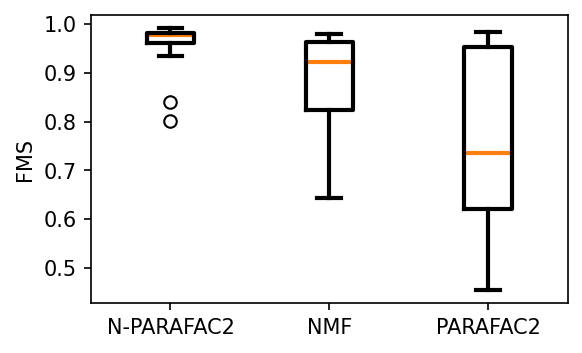

In [9]:
fig, ax = plt.subplots(figsize=(4.1, 2.5), dpi=150, facecolor=(0, 0, 0, 0))

order = results_df.groupby("Model").median().sort_values("FMS", ascending=False).index
results_df.pivot("Dataset", "Model", "FMS",)[order].plot.box(
    ax=ax,
    capprops={"linewidth": 2},
    boxprops={"linewidth": 2},
    whiskerprops={"linewidth": 2},
    flierprops={"linewidth": 2},
    medianprops={"linewidth": 2, "zorder": -1},
)
ax.set_ylabel("FMS")
plt.show()

### Statistical significance

Here, we use a paired Wilcoxon signed-rank test to test whether the nonnegative PARAFAC2 model improves the factor recovery compared to PARAFAC2 and NMF. The Wilcoxon signed-rank test is a nonparametric version of the t-test

In [10]:
fms = results_df.set_index(["Model", "Dataset"])["FMS"]
for model in results_df["Model"].unique():
    if model == "N-PARAFAC2":
        continue
    
    pval = stats.wilcoxon(fms["N-PARAFAC2"], fms[model], alternative="greater").pvalue
    print(f"p-value for N-PARAFAC2 improving recovery compared to {model}: {pval:.2e}")

p-value for N-PARAFAC2 improving recovery compared to PARAFAC2: 2.38e-05
p-value for N-PARAFAC2 improving recovery compared to NMF: 1.97e-04


Thus, by leveraging MatCoupLy’s ability to combine multiple constraints, we can improve the recovery of the underlying components compared to models with just one of the constraints.